In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import pandas as pd
import cv2
import matplotlib.image as mpimg
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, LayerNormalization, LeakyReLU, BatchNormalization, LSTM, Softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model, to_categorical
import graphviz
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Run: Local
folder_link = ""

In [3]:
# Run: Darren
folder_link = "/content/drive/My Drive/comp4211/project/"

In [ ]:
# Run: Newt
folder_link = "/content/drive/My Drive/HKUST/COMP 4211/Project/"

In [88]:
os.listdir(f"{folder_link}image_data/adausdt")
# os.listdir('/content/drive/My Drive/HKUST/COMP 4211/Project/image_data/adausdt')

['validation_output.csv',
 'validation_data.dat',
 'training_output.csv',
 'training_data.dat',
 'testing_output.csv',
 'testing_data.dat']

## Data Processing

In [4]:
train_data = np.load(f"{folder_link}image_data/train_data.npz")["arr_0"]
train_output = pd.read_csv(f"{folder_link}image_data/train_output.csv")
test_data = np.load(f"{folder_link}image_data/test_data.npz")["arr_0"]
test_output = pd.read_csv(f"{folder_link}image_data/test_output.csv")

In [5]:
train_output

,Open time,LogReturns,NormalizedLR
0,1609545600000,-0.019493,-0.206317
1,1609549200000,0.010832,0.114642
2,1609552800000,0.004025,0.042597
3,1609556400000,0.004180,0.044241
4,1609560000000,-0.004065,-0.043026
...,...,...,...
280432,1711908000000,0.002394,0.105351
280433,1711911600000,0.002229,0.113083
280434,1711915200000,-0.002070,-0.104998
280435,1711918800000,-0.000638,-0.032351


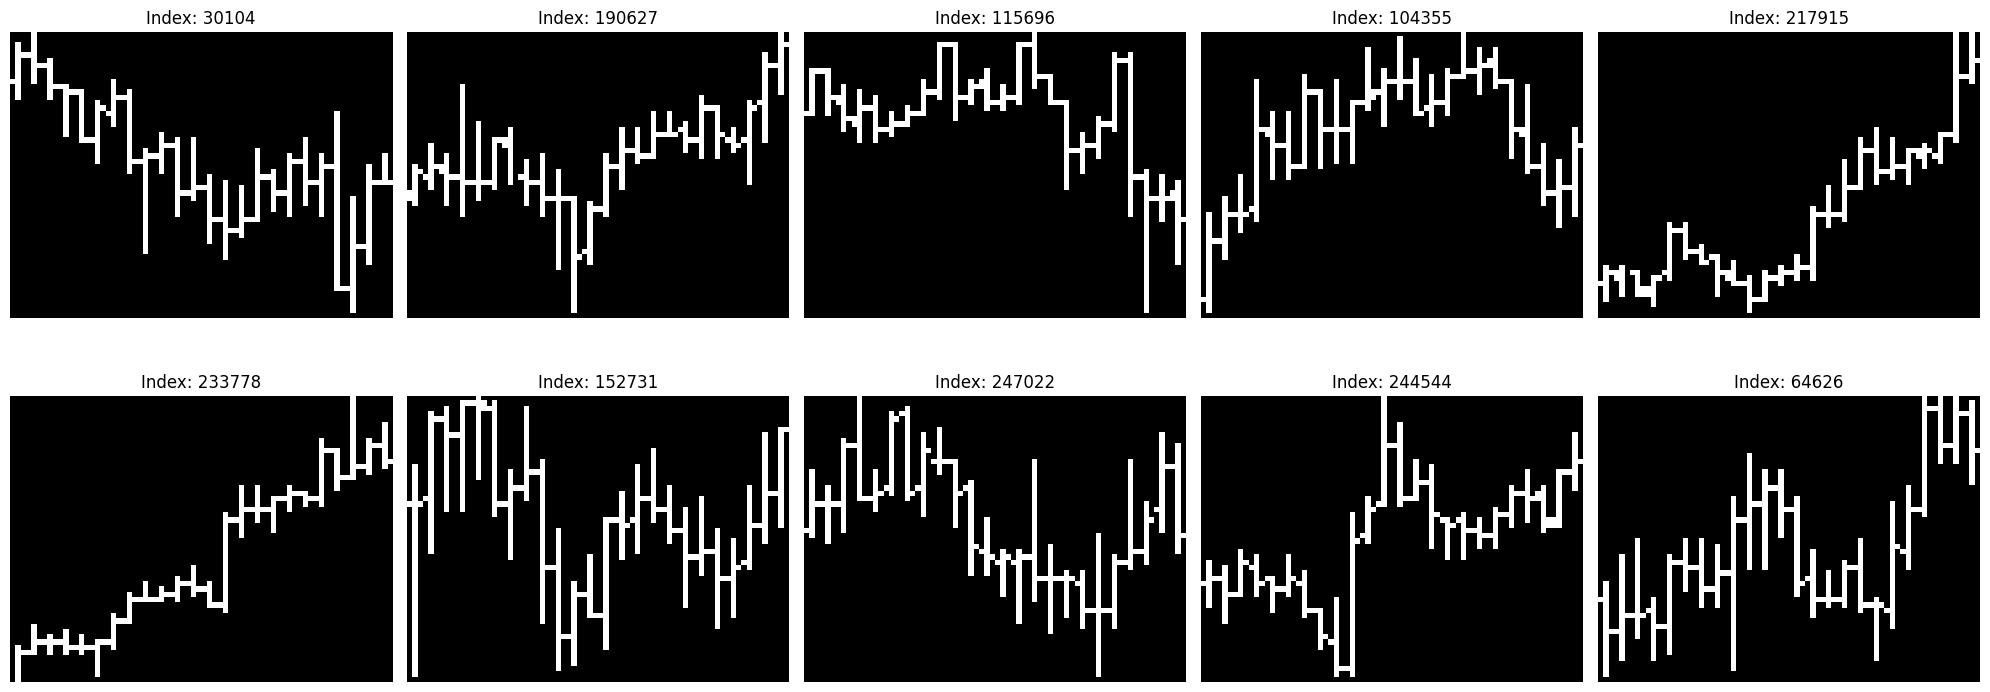

In [6]:
# sample = train_data[0]
# print(sample.shape)
# plt.figure()
# plt.imshow(sample, cmap="gray")

# Plot 10 random images and print their indices
fig, axs = plt.subplots(2, 5, figsize = (20, 8))
for i in range(10):
    index = np.random.randint(0, train_data.shape[0])
    axs[i // 5, i % 5].imshow(train_data[index], cmap = "gray")
    axs[i // 5, i % 5].set_title(f"Index: {index}")
    axs[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

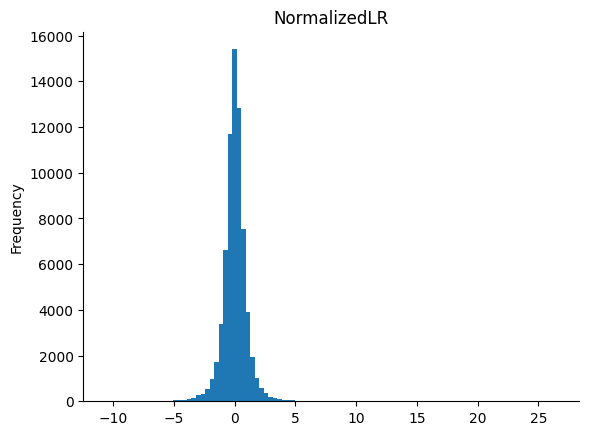

In [98]:
scaler = StandardScaler()
test_output[["NormalizedLR"]] = scaler.fit_transform(test_output[["NormalizedLR"]])

test_output['NormalizedLR'].plot(kind='hist', bins=100, title='NormalizedLR')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [99]:
signs = np.sign(test_output["NormalizedLR"]).values
unique, counts = np.unique(signs, return_counts=True)
print(unique, counts)
print(counts[1] / (counts[0] + counts[1]))

[-1.  1.] [34660 35637]
0.5069490874432764


In [28]:
# transformer = PowerTransformer(method='yeo-johnson')
# test_output['TransformedLR'] = transformer.fit_transform(test_output['NormalizedLR'].values.reshape(-1, 1)).flatten()

# print(f"Skewness: {skew(test_output['NormalizedLR'].values)}")
# print(f"Skewness: {skew(test_output['TransformedLR'].values)}")

# scaler = StandardScaler()
# test_output[["TransformedLR"]] = scaler.fit_transform(test_output[["TransformedLR"]])

# test_output['TransformedLR'].plot(kind='hist', bins=100, title='TransformedLR')
# plt.gca().spines[['top', 'right',]].set_visible(False)

# signs = np.sign(test_output["TransformedLR"]).values
# unique, counts = np.unique(signs, return_counts=True)
# print(unique, counts)
# print(counts[1] / (counts[0] + counts[1]))

## Model

In [140]:
model = Sequential([
    # Layer 1
    Conv2D(64, kernel_size=(5, 3), padding='same', dilation_rate=(3, 1), input_shape=(54, 72, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 1)),

    # Layer 2
    Conv2D(128, kernel_size=(3, 3), padding='same', dilation_rate=(3, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 1)),

    # Layer 3
    Conv2D(256, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.5),

    # FC and Output
    Flatten(),
    Dense(2, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_127 (Conv2D)                  │ (None, 54, 72, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_127              │ (None, 54, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_127 (LeakyReLU)          │ (None, 54, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_127 (MaxPooling2D)     │ (None, 27, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_128 (Conv2D)                  │ (None, 27, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_128              │ (None, 27, 72, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_128 (LeakyReLU)          │ (None, 27, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_128 (MaxPooling2D)     │ (None, 13, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_129 (Conv2D)                  │ (None, 13, 72, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_129              │ (None, 13, 72, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_129 (LeakyReLU)          │ (None, 13, 72, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_129 (MaxPooling2D)     │ (None, 6, 72, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 6, 72, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_42 (Flatten)                 │ (None, 110592)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 2)                   │         221,186 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 593,026 (2.26 MB)

 Trainable params: 592,130 (2.26 MB)

 Non-trainable params: 896 (3.50 KB)

In [143]:
X = train_data.reshape((-1, 54, 72, 1))
y = train_output["NormalizedLR"].values
y = to_categorical(np.where(y < 0, 0, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(X, y, epochs=10, validation_split=0.2, shuffle=True, callbacks=[early_stopping])

model.save('model.h5')
loaded_model = keras.models.load_model('model.h5')

Epoch 1/10
7011/7011 ━━━━━━━━━━━━━━━━━━━━ 108s 15ms/step - accuracy: 0.5056 - loss: 1.2689 - val_accuracy: 0.5105 - val_loss: 0.7021
Epoch 2/10
7011/7011 ━━━━━━━━━━━━━━━━━━━━ 99s 14ms/step - accuracy: 0.5110 - loss: 0.7091 - val_accuracy: 0.5185 - val_loss: 0.6951
Epoch 3/10
7011/7011 ━━━━━━━━━━━━━━━━━━━━ 99s 14ms/step - accuracy: 0.5198 - loss: 0.6996 - val_accuracy: 0.5221 - val_loss: 0.6921
Epoch 4/10
7011/7011 ━━━━━━━━━━━━━━━━━━━━ 99s 14ms/step - accuracy: 0.5222 - loss: 0.6969 - val_accuracy: 0.5296 - val_loss: 0.6917
Epoch 5/10
7011/7011 ━━━━━━━━━━━━━━━━━━━━ 99s 14ms/step - accuracy: 0.5261 - loss: 0.6965 - val_accuracy: 0.5216 - val_loss: 0.6975
Epoch 6/10
7011/7011 ━━━━━━━━━━━━━━━━━━━━ 99s 14ms/step - accuracy: 0.5262 - loss: 0.6964 - val_accuracy: 0.4982 - val_loss: 0.7030


In [146]:
X_test = test_data.reshape((-1, 54, 72, 1))
y_test = np.where(test_output["NormalizedLR"] > 0, 1, 0)

y_pred = np.argmax(model.predict(X_test), axis=1)

accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Accuracy: 0.5207


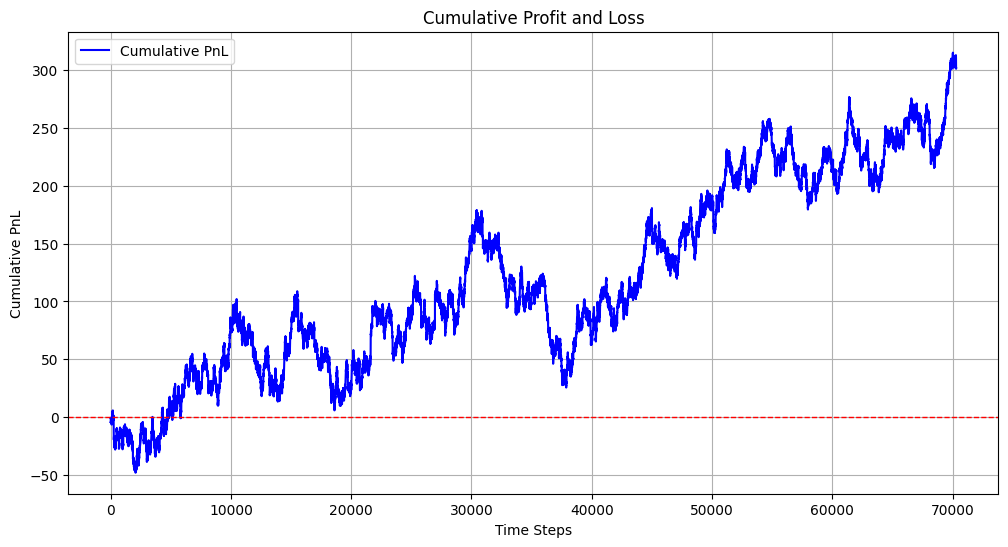

In [147]:
pnl = np.array([])
for guess, change in zip(y_pred, test_output["NormalizedLR"].values):
    pnl = np.append(pnl, guess * change)
cumulative_pnl = np.cumsum(pnl)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_pnl, label='Cumulative PnL', color='blue')
plt.title('Cumulative Profit and Loss')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Draw line at y=0 for reference
plt.legend()
plt.grid()
plt.show()

In [ ]:
y_pred.shape

(70297,)

In [ ]:
test_output["NormalizedLogReturns"].shape

(70297,)

In [ ]:
np.sign(y_pred).shape

(70297,)